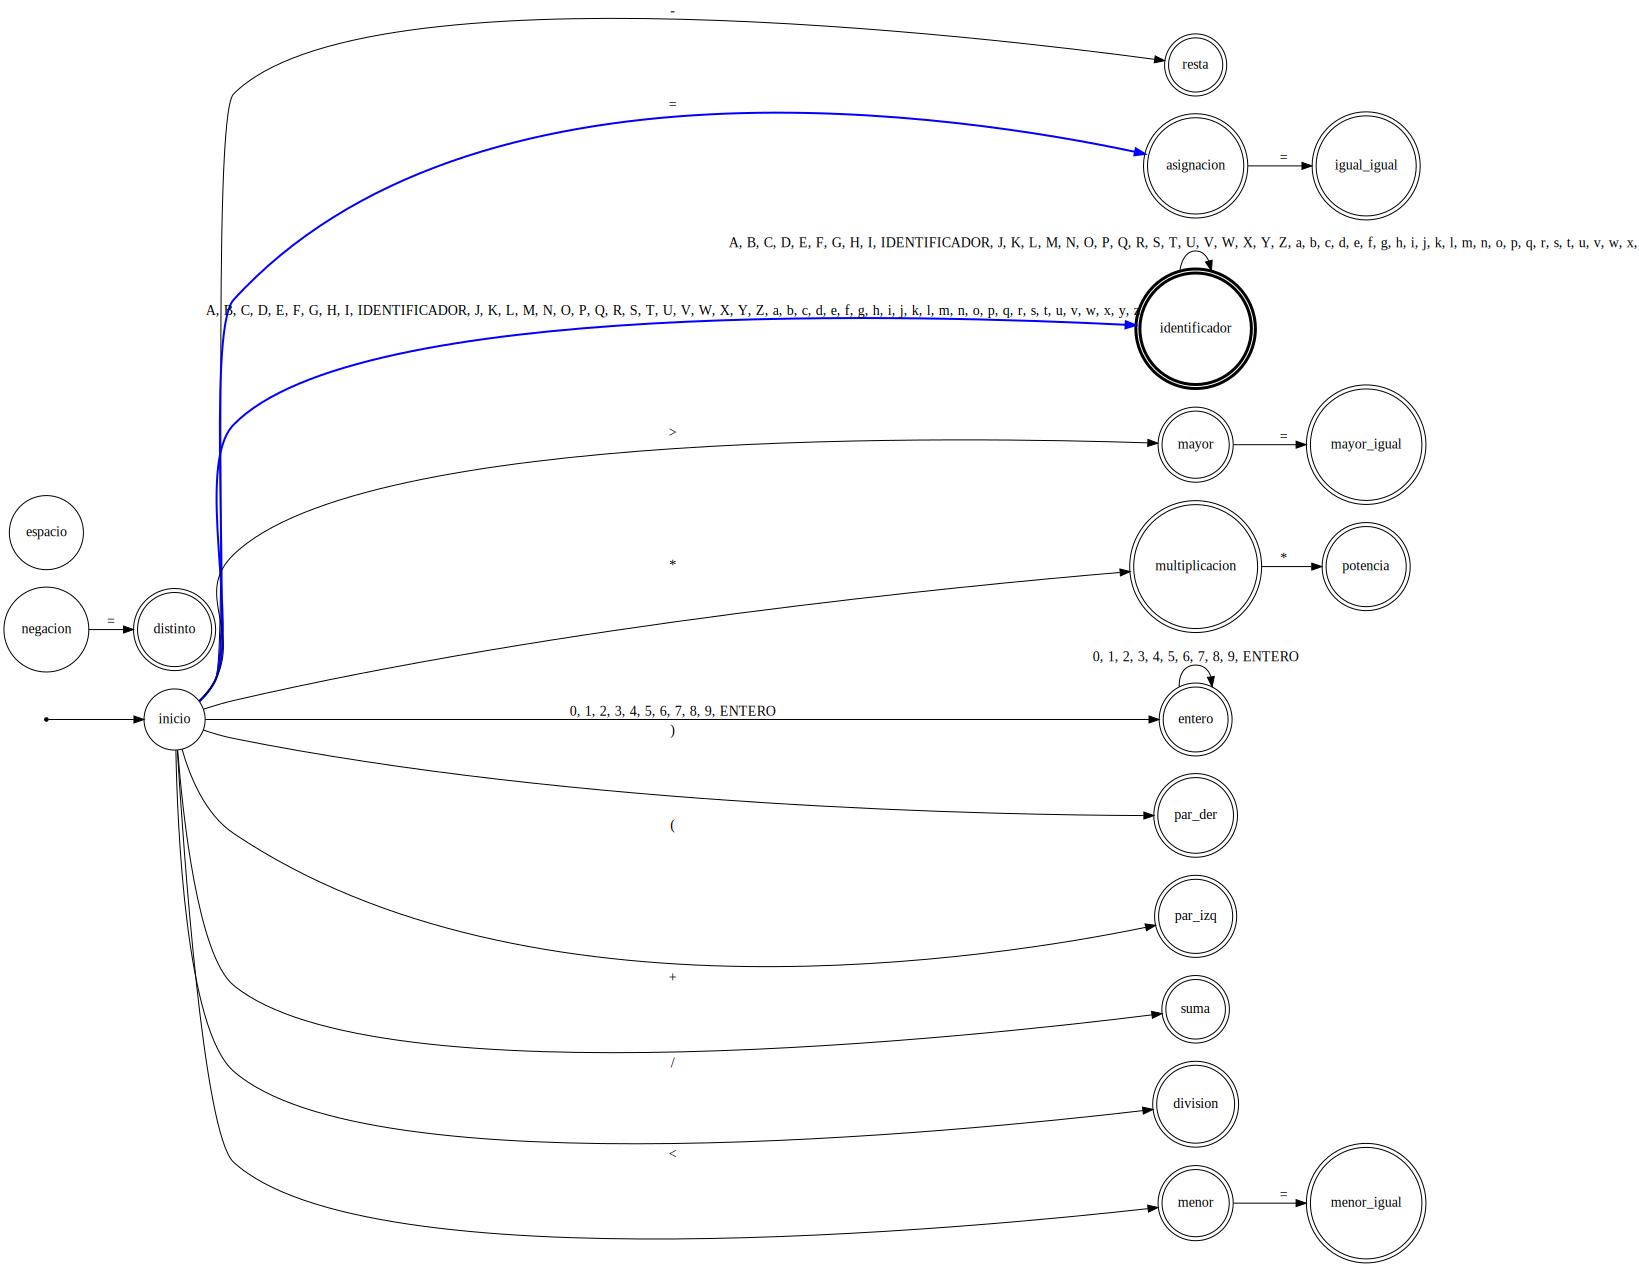

In [ ]:
from dataclasses import dataclass
from typing import Dict, Set, List, Tuple, Optional
import re
from IPython.display import display, HTML
import graphviz


# --------------------------------------------------1. DEFINICIoN DE AFD (Analizador Lexico)--------------------------------------------------


@dataclass
class DFA:
    states: Set[str]
    alphabet: Set[str]
    transition: Dict[Tuple[str, str], str]
    start_state: str
    accept_states: Set[str]

    def step(self, state: str, symbol: str) -> str:
        key = (state, symbol)
        if key not in self.transition:
            raise ValueError(f"No hay transición definida para ({state}, {repr(symbol)})")
        return self.transition[key]

    def simulate(self, input_symbols: List[str]):
        current = self.start_state
        log = []
        for i, sym in enumerate(input_symbols):
            # Si el sImbolo no existe en las transiciones, reinicia
            if (current, sym) not in self.transition:
                # Reinicio de token
                current = self.start_state
            if (current, sym) not in self.transition:
                raise ValueError(f"No hay transición definida para ({current}, {repr(sym)})")
            nxt = self.step(current, sym)
            log.append((i, current, sym, nxt))
            current = nxt
        return current, log

    def accepts(self, input_symbols: List[str]) -> bool:
        final, _ = self.simulate(input_symbols)
        return final in self.accept_states


def draw_dfa(dfa: DFA, highlight_path: Optional[List[Tuple[str, str, str]]] = None,
             highlight_state: Optional[str] = None):
    dot = graphviz.Digraph(format="png")
    dot.attr(rankdir="LR")
    dot.node("", shape="point")  # flecha de inicio

    for s in dfa.states:
        shape = "doublecircle" if s in dfa.accept_states else "circle"
        penwidth = "3" if highlight_state == s else "1"
        dot.node(s, shape=shape, penwidth=penwidth)

    dot.edge("", dfa.start_state)

    edges_labels = {}
    for (src, sym), dst in dfa.transition.items():
        edges_labels.setdefault((src, dst), []).append(sym)

    highlighted_pairs = set((src, dst) for (src, sym, dst) in (highlight_path or []))

    for (src, dst), syms in edges_labels.items():
        label = ", ".join(sorted(syms))
        if (src, dst) in highlighted_pairs:
            dot.edge(src, dst, label=label, color="blue", penwidth="2")
        else:
            dot.edge(src, dst, label=label)
    return dot


def steps_table(log):
    """Muestra una tabla HTML simple con el log de pasos."""
    if not log:
        display(HTML("No hubo transiciones (entrada vacía)."))
        return
    rows = ["# Estado actual | Símbolo | Próximo estado"]
    for i, s, sym, nxt in log:
        rows.append(f"{i} | {s} | {sym} | {nxt}")
    html = "<pre>" + "\n".join(rows) + "</pre>"
    display(HTML(html))


# --------------------------------------------------2. CONFIGURACIoN DEL LEXICO Y TOKENS--------------------------------------------------

estados = {"inicio","identificador","entero","espacio",
           "suma","resta","multiplicacion","potencia","division",
           "asignacion","menor","mayor","igual_igual","menor_igual",
           "mayor_igual","negacion","distinto","par_izq","par_der"}

alfabeto = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789+-*/=<>()! ")

transiciones = {
    ("inicio", "+"): "suma",
    ("inicio", "-"): "resta",
    ("inicio", "*"): "multiplicacion",
    ("inicio", "/"): "division",
    ("inicio", "="): "asignacion",
    ("inicio", "<"): "menor",
    ("inicio", ">"): "mayor",
    ("inicio", "("): "par_izq",
    ("inicio", ")"): "par_der",
    ("inicio", "IDENTIFICADOR"): "identificador",
    ("inicio", "ENTERO"): "entero",
    ("identificador", "IDENTIFICADOR"): "identificador",
    ("entero", "ENTERO"): "entero",
    ("multiplicacion", "*"): "potencia",
    ("asignacion", "="): "igual_igual",
    ("menor", "="): "menor_igual",
    ("mayor", "="): "mayor_igual",
    ("negacion", "="): "distinto",
}
# Agregar transiciones para letras (identificadores)
for c in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ":
    transiciones[("inicio", c)] = "identificador"
    transiciones[("identificador", c)] = "identificador"

# Agregar transiciones para digitos (enteros)
for d in "0123456789":
    transiciones[("inicio", d)] = "entero"
    transiciones[("entero", d)] = "entero"

estados_aceptacion = {"identificador","entero","suma","resta","multiplicacion","potencia",
                      "division","asignacion","igual_igual","menor","menor_igual",
                      "mayor","mayor_igual","distinto","par_izq","par_der"}


lexer_dfa = DFA(
    states=estados,
    alphabet=alfabeto,
    transition=transiciones,
    start_state="inicio",
    accept_states=estados_aceptacion
)

# Visualización del AFD
seq = list("A=B")
final1, log1 = lexer_dfa.simulate(seq)
steps_table(log1)
display(draw_dfa(lexer_dfa, highlight_path=[(s, sym, nxt) for (_, s, sym, nxt) in log1],
                  highlight_state=final1))

In [ ]:

# --------------------------------------------------3. FUNCION DE TOKENIZACION--------------------------------------------------

PALABRAS_RESERVADAS = {"IF","THEN","ENDIF","PRINT"}

def reclasificar_identificador(lexema: str) -> str:
    return "RESERVADA" if lexema.upper() in PALABRAS_RESERVADAS else "ID"

def tokenizar(cadena: str) -> List[Tuple[str, str]]:
    patron = r"[A-Za-z_]\w*|\d+|==|<=|>=|!=|\*\*|[+\-*/=<>()]"
    tokens = re.findall(patron, cadena)
    resultado = []
    for t in tokens:
        if re.match(r"^[A-Za-z_]\w*$", t):
            tipo = reclasificar_identificador(t)
        elif re.match(r"^\d+$", t):
            tipo = "NUM"
        elif t in {"+","-","*","/","**"}:
            tipo = "OP_ARIT"
        elif t in {"=","=="}:
            tipo = "ASIGN"
        elif t in {"<",">","<=",">=","!="}:
            tipo = "OP_REL"
        elif t in {"(",")"}:
            tipo = "PAREN"
        else:
            tipo = "DESCONOCIDO"
        resultado.append((tipo,t))
    return resultado


#-------------------------------------------------- 4.1 CLASE PARA NODOS DEL ARBOL SINTACTICO--------------------------------------------------


class Node:
    def __init__(self, label, children=None):
        self.label = label
        self.children = children or []

    def add(self, node):
        self.children.append(node)
        return node

    def __repr__(self):
        return self.label



#-------------------------------------------------- 4.2 PARSER --------------------------------------------------

class Parser:
    def __init__(self, tokens):
        self.tokens = tokens + [("EOF","")]
        self.pos = 0

    def actual(self):
        return self.tokens[self.pos]

    def coincidir(self, tipo):
        if self.actual()[0] == tipo:
            lex = self.actual()[1]
            self.pos += 1
            return Node(lex)
        raise SyntaxError(f"Se esperaba {tipo}, se encontro {self.actual()}")

    def parse(self):
        print("\n=== ANALISIS SINTÁCTICO ===")
        raiz = self.programa()
        print("+++ Programa sintacticamente valido.")
        return raiz

    # <programa>: sentencia programa | ε
    def programa(self):
        # detener si llegamos a ENDIF o EOF
        if self.actual()[0] in ("EOF",) or self.actual()[1].upper() == "ENDIF":
            return Node("ε")

        nodo_prog = Node("Programa")
        nodo_prog.add(self.sentencia())
        # si el siguiente token es ENDIF, no seguir recursion
        if not (self.actual()[0] == "RESERVADA" and self.actual()[1].upper() == "ENDIF"):
            nodo_prog.add(self.programa())
        return nodo_prog

    # <sentencia>: asign | if | print
    def sentencia(self):
        tk = self.actual()
        if tk[0] == "ID":
            nodo = Node("Sentencia: Asignación")
            nodo.add(self.asignacion())
            return nodo
        if tk[1].upper() == "IF":
            nodo = Node("Sentencia: IF")
            nodo.add(self.if_stmt())
            return nodo
        if tk[1].upper() == "PRINT":
            nodo = Node("Sentencia: PRINT")
            nodo.add(self.print_stmt())
            return nodo
        raise SyntaxError(f"Sentencia inesperada: {tk}")

    # asign: ID ASIGN expr
    def asignacion(self):
        nodo = Node("Asignación")
        nodo.add(self.coincidir("ID"))
        nodo.add(self.coincidir("ASIGN"))
        nodo.add(self.expresion())
        return nodo

    # if : IF PAREN cond PAREN THEN asign ENDIF
    def if_stmt(self):
        nodo = Node("IF")
        self.coincidir("RESERVADA")     # IF
        self.coincidir("PAREN")
        nodo_cond = self.condicion()
        nodo.add(nodo_cond)
        self.coincidir("PAREN")
        self.coincidir("RESERVADA")     # THEN
        # procesar una sola asignación dentro del THEN
        nodo.add(self.asignacion())
        self.coincidir("RESERVADA")     # ENDIF
        nodo.add(Node("ENDIF"))
        print("Estructura IF valida")
        return nodo

    def print_stmt(self):
        self.coincidir("RESERVADA")
        nodo = Node("PRINT")
        nodo.add(self.coincidir(self.actual()[0]))
        print(" Sentencia PRINT valida")
        return nodo

    def condicion(self):
        nodo = Node("Condicion")
        nodo.add(self.coincidir("ID"))
        nodo.add(self.coincidir("OP_REL"))
        nodo.add(self.coincidir("NUM"))
        return nodo

    def expresion(self):
        nodo = Node("Expresión")
        nodo.add(self.term())
        while self.actual()[0] == "OP_ARIT":
            nodo.add(self.coincidir("OP_ARIT"))
            nodo.add(self.term())
        return nodo

    def term(self):
        nodo = Node("Termino")
        if self.actual()[0] in ("ID","NUM"):
            nodo.add(self.coincidir(self.actual()[0]))
            return nodo
        raise SyntaxError(f"Token inesperado: {self.actual()}")



#-------------------------------------------------- 4.3 VISUALIZACION DEL ARBOL SINTACTICO--------------------------------------------------


def dibujar_arbol(node, graph=None, parent=None):
    if graph is None:
        graph = graphviz.Digraph(format="png")
        graph.attr(rankdir="TB", size="8,10")

    graph.node(str(id(node)), node.label)
    if parent:
        graph.edge(str(id(parent)), str(id(node)))

    for child in node.children:
        dibujar_arbol(child, graph, node)
    return graph



In [ ]:

#-------------------------------------------------- 5. PRUEBAS Y RESULTADOS ESPERADOS--------------------------------------------------


entradas = [
    # VALIDAS
    "A = 3 + 5 * 2",
    "IF (A > 5) THEN A = 1 ENDIF",
    "IF (A > 5) THEN PRINT A ENDIF",
    "IF (A > 5) THEN A = 1 PRINT A ENDIF",
    "PRINT 100",
    # INVALIDAS
    "A = ",
    "IF A > 5 THEN A = 1 ENDIF",   # falta paréntesis
    "IF (A > 5) THEN A = 1",       # falta ENDIF
]

for entrada in entradas:
    print("\n==============================")
    print("Entrada:", entrada)
    print("==============================")
    try:
        toks = tokenizar(entrada)
        print("\nTokens:")
        for t in toks:
            print(" ", t)
        parser = Parser(toks)
        parser.parse()
    except Exception as e:
        print("- Error:", e)


Entrada: A = 3 + 5 * 2

Tokens:
  ('ID', 'A')
  ('ASIGN', '=')
  ('NUM', '3')
  ('OP_ARIT', '+')
  ('NUM', '5')
  ('OP_ARIT', '*')
  ('NUM', '2')

=== ANÁLISIS SINTÁCTICO ===
✅ Programa sintácticamente válido.

Entrada: IF (A > 5) THEN A = 1 ENDIF

Tokens:
  ('RESERVADA', 'IF')
  ('PAREN', '(')
  ('ID', 'A')
  ('OP_REL', '>')
  ('NUM', '5')
  ('PAREN', ')')
  ('RESERVADA', 'THEN')
  ('ID', 'A')
  ('ASIGN', '=')
  ('NUM', '1')
  ('RESERVADA', 'ENDIF')

=== ANÁLISIS SINTÁCTICO ===
✔ Estructura IF válida
✅ Programa sintácticamente válido.

Entrada: IF (A > 5) THEN PRINT A ENDIF

Tokens:
  ('RESERVADA', 'IF')
  ('PAREN', '(')
  ('ID', 'A')
  ('OP_REL', '>')
  ('NUM', '5')
  ('PAREN', ')')
  ('RESERVADA', 'THEN')
  ('RESERVADA', 'PRINT')
  ('ID', 'A')
  ('RESERVADA', 'ENDIF')

=== ANÁLISIS SINTÁCTICO ===
- Error: Se esperaba ID, se encontró ('RESERVADA', 'PRINT')

Entrada: IF (A > 5) THEN A = 1 PRINT A ENDIF

Tokens:
  ('RESERVADA', 'IF')
  ('PAREN', '(')
  ('ID', 'A')
  ('OP_REL', '>')
  


Tokens:
  ('RESERVADA', 'IF')
  ('PAREN', '(')
  ('ID', 'A')
  ('OP_REL', '>')
  ('NUM', '5')
  ('PAREN', ')')
  ('RESERVADA', 'THEN')
  ('ID', 'A')
  ('ASIGN', '=')
  ('NUM', '1')
  ('RESERVADA', 'ENDIF')

=== ANÁLISIS SINTÁCTICO ===
✔ Estructura IF válida
✅ Programa sintácticamente válido.


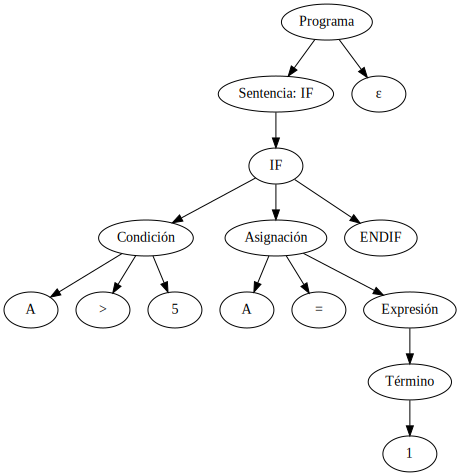

In [ ]:
entrada = "IF (A > 5) THEN A = 1 ENDIF"
toks = tokenizar(entrada)
print("\nTokens:")
for t in toks:
    print(" ", t)

parser = Parser(toks)
arbol = parser.parse()

# Dibujar árbol sintáctico
grafico = dibujar_arbol(arbol)
grafico.render(filename="arbol_sintactico", cleanup=True)
display(grafico)

In [ ]:
# Interfaz de usuario
from google.colab import files
print("Este programa es un analizador léxico, escribe algún input para probarlo")
cadena = input("Escribe aqui (ej: if(true) ): ")
print(cadena)

print(f"\nEntrada: {cadena}")
try:
    toks = tokenizar(cadena)
    for t in toks:
        print("->", t)
    csv_filename = "tokens.txt"
    # Guardar tokens en un archivo
    with open(csv_filename, "w", encoding="utf-8") as f:
        f.write(f"Entrada: {cadena}\n")
        for t in toks:
            f.write(f"{t}\n")

    files.download(csv_filename)
    print("\n+ Tokens guardados en 'tokens.txt'")

except ValueError as e:
    print("ERROR:", e)

In [ ]:

# --------------------------------------------------6. INTERFAZ: ANÁLISIS DE ARCHIVO .TXT--------------------------------------------------

from google.colab import files

print("=== ANALIZADOR LEXICO Y SINTACTICO – FORTRAN77 ===")
print("Sube un archivo .txt que contenga varias líneas de código (ejemplo: programa_fortran.txt)\n")

# Subir archivo desde el equipo
uploaded = files.upload()

# Tomar el primer archivo subido
filename = list(uploaded.keys())[0]
print(f"\nArchivo cargado: {filename}\n{'-'*60}")

# Leer contenido
with open(filename, "r", encoding="utf-8") as f:
    lineas = f.readlines()

# Analizar linea por linea
resultados = []
for idx, linea in enumerate(lineas, start=1):
    linea = linea.strip()
    if not linea:
        continue
    print(f"\nLinea {idx}: {linea}")
    try:
        toks = tokenizar(linea)
        for t in toks:
            print("   ->", t)
        try:
            parser = Parser(toks)
            parser.parse()
            resultados.append((idx, linea, "VALIDA"))
        except Exception as e:
            print("   ---- Error sintáctico:", e)
            resultados.append((idx, linea, f"Error sintactico: {e}"))
    except Exception as e:
        print("   ---- Error lexico:", e)
        resultados.append((idx, linea, f"Error lexico: {e}"))

# Guardar resultados en un archivo
output_file = "tokens_resultado.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write("=== RESULTADOS DE ANALISIS ===\n")
    for r in resultados:
        f.write(f"Línea {r[0]}: {r[1]} --> {r[2]}\n")

files.download(output_file)
print("\n+++ Resultados guardados en 'tokens_resultado.txt'")
